In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from transformers import DistilBertTokenizer, TFDistilBertModel
import librosa
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# **Additive Attention Layer**
class AdditiveAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.attention_dense = layers.Dense(1, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.01))

    def call(self, inputs):
        attention = self.attention_dense(inputs)
        attention_weights = tf.nn.softmax(attention, axis=1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context_vector

In [3]:
# **1. Chuẩn bị Dữ liệu Voice**
def extract_mfcc(audio_path, n_mfcc=13, sr=16000):
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # (time_steps, features)

def prepare_voice_data(csv_file):
    data = pd.read_csv(csv_file)
    X_voice, y = [], []
    for _, row in data.iterrows():
        mfcc = extract_mfcc(row['File_path'])
        X_voice.append(mfcc)
        y.append(row['Label'])
    return X_voice, np.array(y)

def pad_voice_features(features):
    max_length = max([feature.shape[0] for feature in features])
    padded_features = []
    for feature in features:
        padding = np.zeros((max_length - feature.shape[0], feature.shape[1]))
        padded_features.append(np.vstack([feature, padding]))
    return np.array(padded_features), max_length


In [26]:
# Load Voice Data
X_train_voice_raw, y_train = prepare_voice_data('D:/download/AI_Project/new_dataset_7_6_s/12_03/new_audio_train_theo_transcript.csv')
X_val_voice_raw, y_val = prepare_voice_data('D:/download/AI_Project/new_dataset_7_6_s/12_03/new_audio_val_theo_transcript.csv')
X_test_voice_raw, y_test = prepare_voice_data('D:/download/AI_Project/new_dataset_7_6_s/12_03/new_audio_test_theo_transcript.csv')

# Padding Voice Features
X_train_voice, max_length_voice_train = pad_voice_features(X_train_voice_raw)
X_val_voice, max_length_voice_val = pad_voice_features(X_val_voice_raw)
X_test_voice, max_length_voice_test = pad_voice_features(X_test_voice_raw)

# Ensure all datasets have the same max length
max_length_voice = max(max_length_voice_train, max_length_voice_val, max_length_voice_test)
X_train_voice = np.array([np.pad(x, ((0, max_length_voice - x.shape[0]), (0, 0)), 'constant') for x in X_train_voice])
X_val_voice = np.array([np.pad(x, ((0, max_length_voice - x.shape[0]), (0, 0)), 'constant') for x in X_val_voice])
X_test_voice = np.array([np.pad(x, ((0, max_length_voice - x.shape[0]), (0, 0)), 'constant') for x in X_test_voice])


In [27]:
# **2. Chuẩn bị Dữ liệu Text**
# **2. Chuẩn bị Dữ liệu Text (Toàn bộ đoạn văn bản)**
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
def encode_full_text(text, max_len=50):
    # Ensure text is a string and tokenize it properly
    if isinstance(text, str):  # If a single string, process it
        inputs = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="tf")
    else:  # If it's a list of strings, tokenize as batch
        inputs = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="tf")
    
    outputs = distilbert_model(inputs["input_ids"])
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()

def prepare_text_data(csv_file):
    data = pd.read_csv(csv_file)
    X_full_text = data['Processed_Text'].values  # Toàn bộ đoạn văn bản
    
    # Ensure each item in X_full_text is a string before passing to tokenizer
    X_encoded_text = [encode_full_text(str(text)) for text in X_full_text]  # Mã hóa toàn bộ đoạn văn bản
    y = data['Label'].values
    return X_encoded_text, y

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [28]:
# Load Text Data
X_train_text, _ = prepare_text_data('D:/download/AI_Project/new_dataset_7_6_s/12_03/train_transcripts_processed.csv')
X_val_text, _ = prepare_text_data('D:/download/AI_Project/new_dataset_7_6_s/12_03/val_transcripts_processed.csv')
X_test_text, _ = prepare_text_data('D:/download/AI_Project/new_dataset_7_6_s/12_03/test_transcripts_processed.csv')

# Padding Text Features (Giữ lại padding cho các đoạn văn bản)
def pad_text_features(features, max_len):
    padded_features = []
    for feature in features:
        if feature.shape[0] < max_len:
            padding = np.zeros((max_len - feature.shape[0], feature.shape[1]))
            padded_features.append(np.vstack([feature, padding]))
        else:
            padded_features.append(feature[:max_len])
    return np.array(padded_features)

max_len_text = 46  # Fixed maximum length for entire document, bạn có thể điều chỉnh nếu cần
X_train_text = pad_text_features(X_train_text, max_len_text)
X_val_text = pad_text_features(X_val_text, max_len_text)
X_test_text = pad_text_features(X_test_text, max_len_text)


In [29]:
# **3. Xây dựng Mô hình Multimodal**
# **Voice Branch**
voice_input = layers.Input(shape=(max_length_voice, 13))  # MFCC only
voice_cnn = layers.Conv1D(64, kernel_size=3, activation="relu")(voice_input)
voice_cnn = layers.MaxPooling1D(pool_size=2)(voice_cnn)
voice_bilstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3))(voice_cnn)
voice_attention = AdditiveAttention()(voice_bilstm)

# **Text Branch (Hierarchical Architecture)**
# **Text Branch (Hierarchical Architecture)**
text_input = layers.Input(shape=(max_len_text, 768))  # Mỗi đoạn văn bản đã được mã hóa
# Turn-level Encoder (bây giờ bỏ qua turn-level)
turn_bilstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(text_input)
turn_attention = AdditiveAttention()(turn_bilstm)


# Fused Model tiếp tục giữ nguyên như trước, phần Fusion vẫn như cũ
fused = layers.concatenate([voice_attention, turn_attention])
fused = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(fused)
fused = layers.Dropout(0.3)(fused)
output = layers.Dense(1, activation="sigmoid")(fused)

# Compile Model
model = Model(inputs=[voice_input, text_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 469, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 467, 64)   │      2,560 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 233, 64)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 46, 768)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 233, 128)  │     66,048 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 46, 256)   │    918,528 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 128)       │        129 │ bidirectional_2[… │
│ (AdditiveAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 256)       │        257 │ bidirectional_3[… │
│ (AdditiveAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ additive_attenti… │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     49,280 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,036,931 (3.96 MB)

 Trainable params: 1,036,931 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# **4. Train Model**
history = model.fit(
    [X_train_voice, X_train_text], y_train,
    validation_data=([X_val_voice, X_val_text], y_val),
    epochs=200, batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
    ]
)

Epoch 1/200


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_14', 'keras_tensor_20']. Received: the structure of inputs=('*', '*')
  warnings.warn(


549/549 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.6850 - loss: 2.8209 - val_accuracy: 0.6925 - val_loss: 0.6224 - learning_rate: 0.0010
Epoch 2/200
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6968 - loss: 0.6214 - val_accuracy: 0.6925 - val_loss: 0.6144 - learning_rate: 0.0010
Epoch 3/200
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6951 - loss: 0.6170 - val_accuracy: 0.6925 - val_loss: 0.6065 - learning_rate: 0.0010
Epoch 4/200
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6890 - loss: 0.6172 - val_accuracy: 0.6925 - val_loss: 0.6044 - learning_rate: 0.0010
Epoch 5/200
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6877 - loss: 0.6107 - val_accuracy: 0.6925 - val_loss: 0.5994 - learning_rate: 0.0010
Epoch 6/200
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6887 - loss: 0.6056 - val_accuracy: 0.6925 - val_loss: 0.5961 - learning_rate: 0.0010
Epoch 7/200
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6922 - loss: 

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8760 - loss: 0.3309
Test Accuracy: 0.8769
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


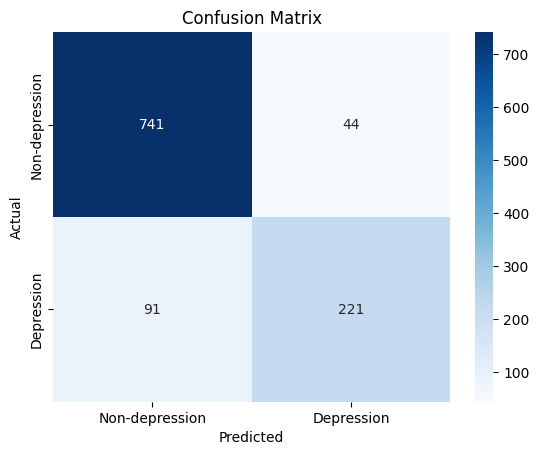

                precision    recall  f1-score   support

Non-depression       0.89      0.94      0.92       785
    Depression       0.83      0.71      0.77       312

      accuracy                           0.88      1097
     macro avg       0.86      0.83      0.84      1097
  weighted avg       0.87      0.88      0.87      1097



In [31]:
# **5. Evaluate Model**
loss, accuracy = model.evaluate([X_test_voice, X_test_text], y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
y_pred = (model.predict([X_test_voice, X_test_text]) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-depression", "Depression"], yticklabels=["Non-depression", "Depression"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Non-depression", "Depression"]))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


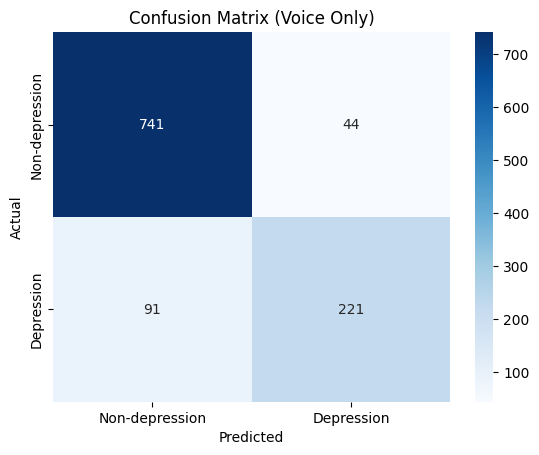

In [35]:
y_pred_voice = (model.predict([X_test_voice, np.zeros_like(X_test_text)]) > 0.5).astype(int)
cm_voice = confusion_matrix(y_test, y_pred_voice)
sns.heatmap(cm_voice, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-depression", "Depression"], yticklabels=["Non-depression", "Depression"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Voice Only)")
plt.show()


275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


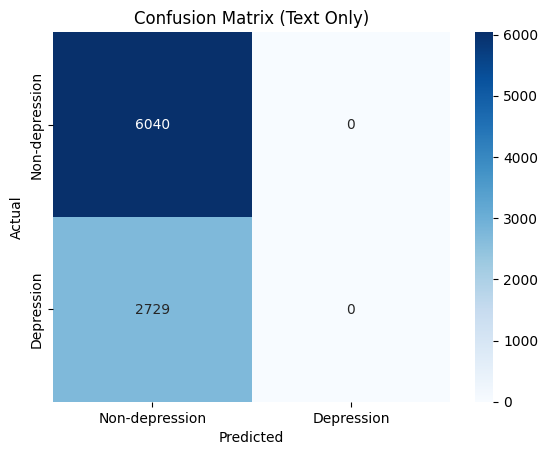

In [38]:
y_pred_text = (model.predict([np.zeros_like(X_train_voice), X_train_text]) > 0.5).astype(int)
cm_text = confusion_matrix(y_train, y_pred_text)
sns.heatmap(cm_text, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-depression", "Depression"], yticklabels=["Non-depression", "Depression"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Text Only)")
plt.show()
